## 1 Compare Hand-coded vs. NN policy

### 1.1 Hand-coded

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


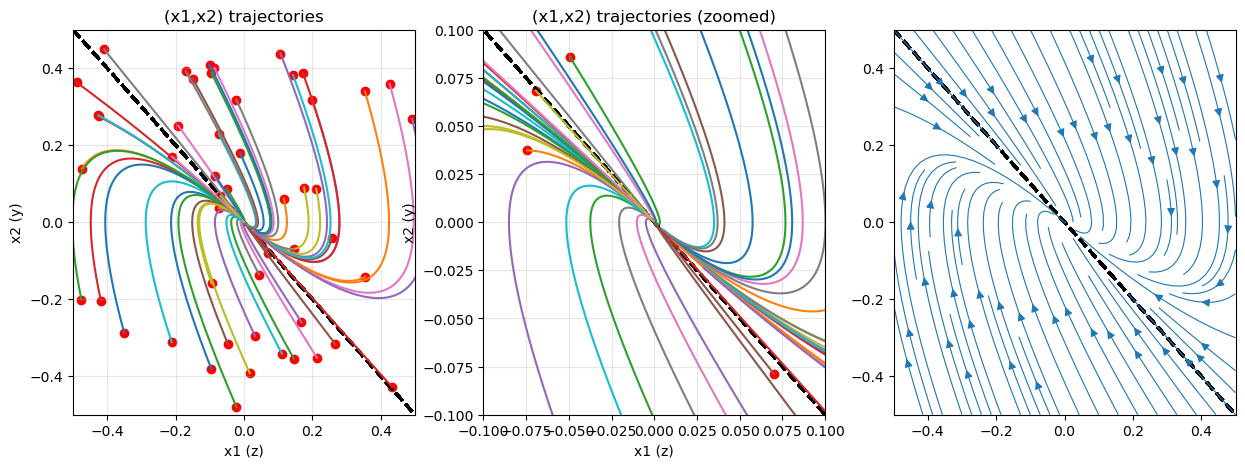

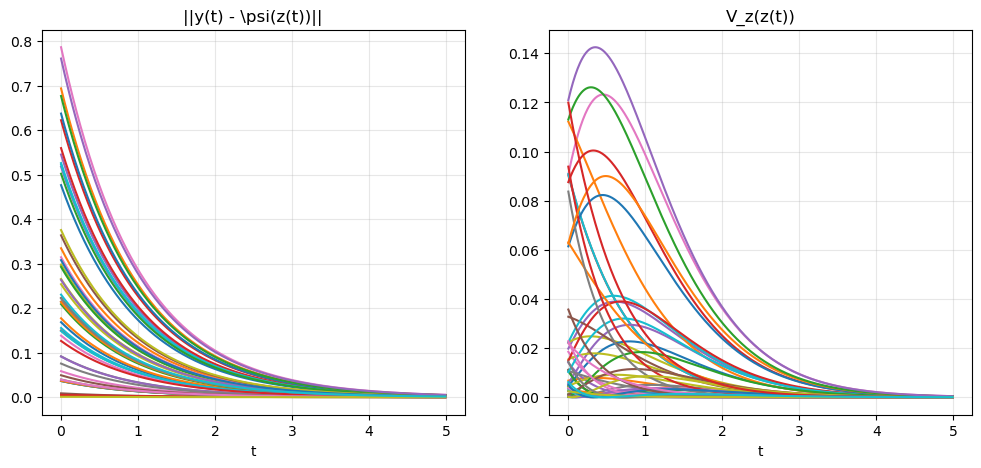

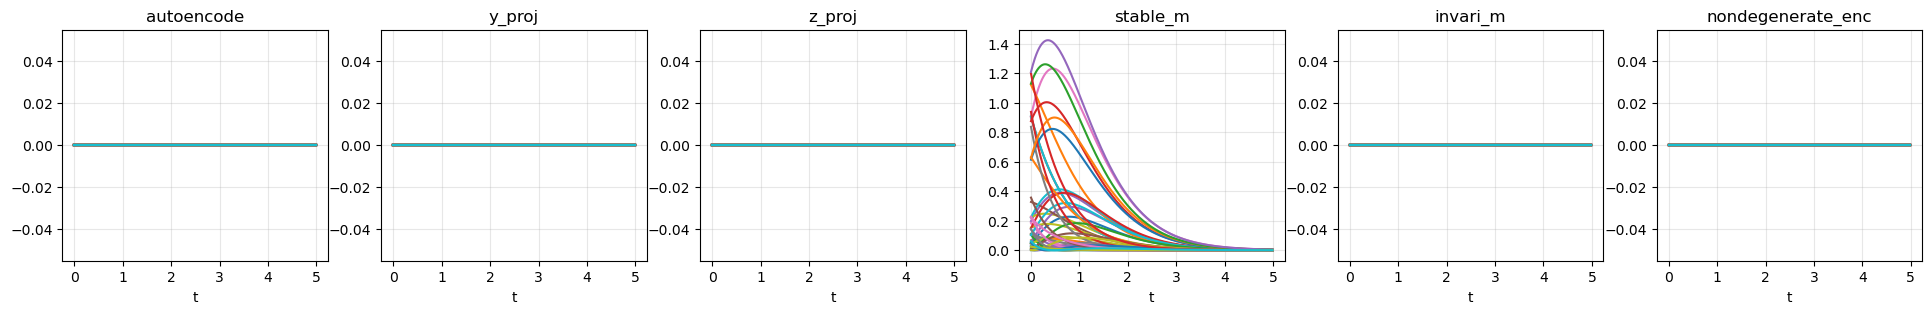

In [12]:
%load_ext autoreload
%autoreload 2

import os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax, flax
from einops import rearrange
from double_integrator import *
from my_train import *


box_width = 0.5

cfg_rom = CfgDIROM()
cfg_rollout = CfgRollout()
rng = jax.random.PRNGKey(42)

rom = DoubleIntegratorROM(cfg_rom=cfg_rom)
ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
x0s = jax.random.uniform(rng, (50, 2), minval=-box_width, maxval=box_width)

integrator = Integrator(
    solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()),
    ts=ts,
)

rom = DoubleIntegratorROM(cfg_rom=cfg_rom)

ret = integrator.apply(x0s, rom)
aux_ret = integrator.post_apply(ret, rom)
loss_ret = integrator.compute_loss(ret, rom)

make_plots(rom, ret, aux_ret, loss_ret, box_width=box_width)

### 1.2 NN-based, hardcoded params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1,) (50, 1)


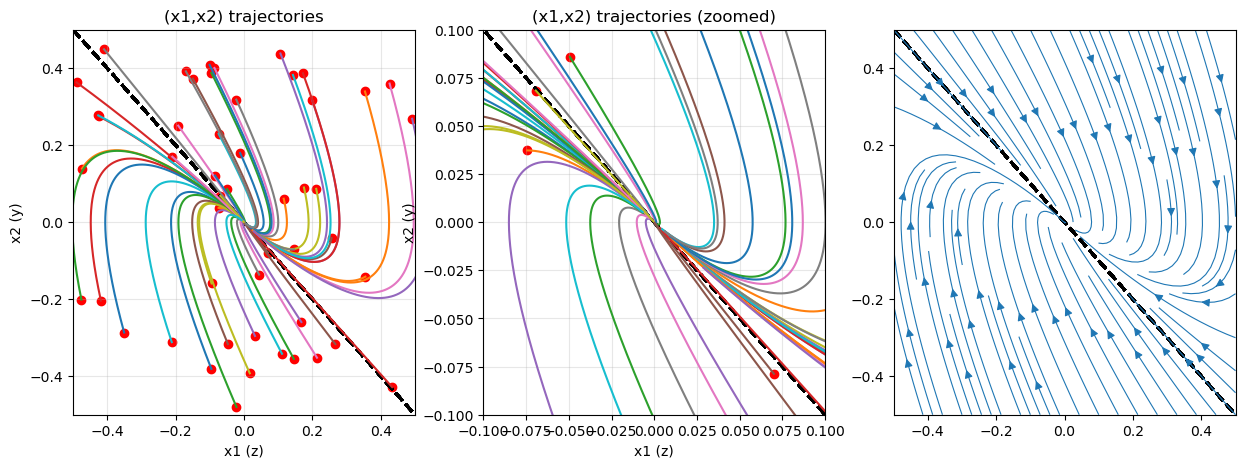

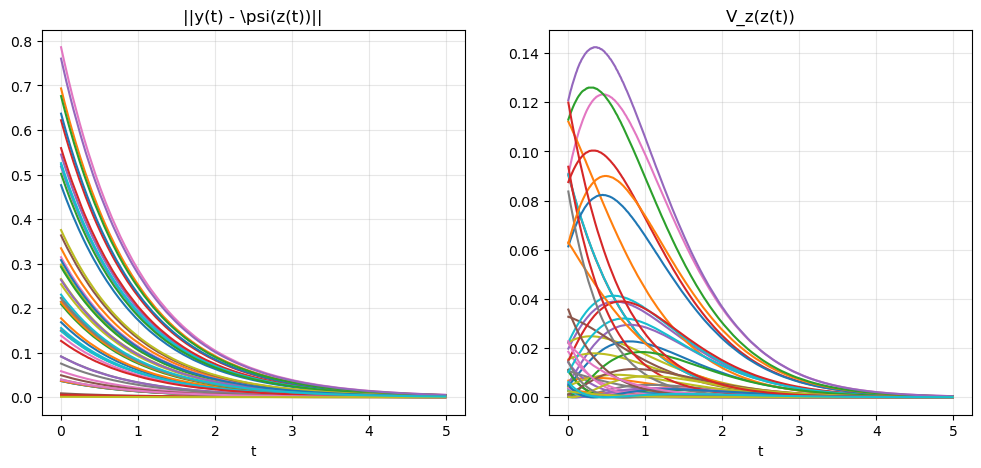

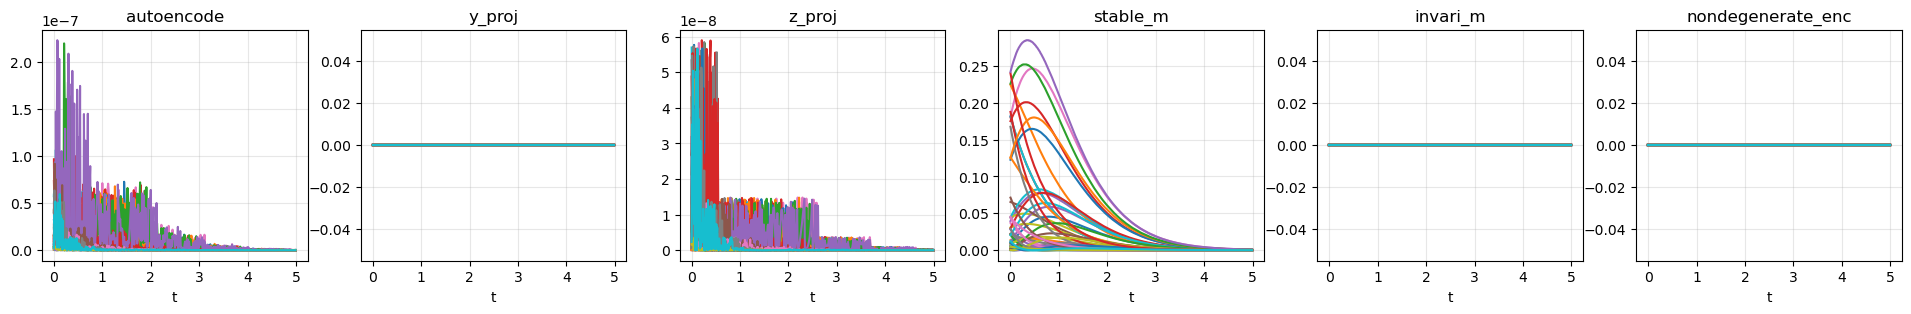

In [4]:
%load_ext autoreload
%autoreload 2


import os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax, flax
from double_integrator import *
from my_train import *



box_width = 0.5

cfg_rom = CfgDIROM()
cfg_rollout = CfgRollout()
rng = jax.random.PRNGKey(42)

params = flax.core.FrozenDict({}) # place holder for NN parameters
ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
x0s = jax.random.uniform(rng, (50, 2), minval=-box_width, maxval=box_width)

rom = NNDoubleIntegratorROM(cfg_rom=cfg_rom)
rom.hardcode_nn_params()

integrator = Integrator(solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()), ts=ts)

ret1 = rom.policy_v(1.0, 1.0)
ret2 = jax.vmap(rom.policy_v, in_axes=(0, 0))(
    jnp.ones((50,)),
    jnp.ones((50,))
)

print(ret1.shape, ret2.shape)

ret = integrator.apply(x0s, rom)
aux_ret = integrator.post_apply(ret, rom)
loss_ret = integrator.compute_loss(ret, rom)
make_plots(rom, ret, aux_ret, loss_ret, box_width=box_width)

    

## 2. Actually Learn NN Policy

Before training:
{'nn_decoder': {'bias': None,
                'kernel': Array([[-1.5153334 , -1.3828858 ],
       [ 0.15761374, -0.2707644 ]], dtype=float32)},
 'nn_encoder': {'bias': None,
                'kernel': Array([[ 0.75672996, -0.6857006 ],
       [-0.5688339 , -0.8757607 ]], dtype=float32)},
 'nn_fy': {'bias': None, 'kernel': Array([[1.3595891]], dtype=float32)},
 'nn_fz': {'bias': None, 'kernel': Array([[0.48590264],
       [0.24484356]], dtype=float32)},
 'nn_gy': {'bias': Array([1.], dtype=float32), 'kernel': Array([[0.]], dtype=float32)},
 'nn_psi': {'bias': None, 'kernel': Array([[-0.4]], dtype=float32)}}


100%|██████████| 10/10 [00:46<00:00,  4.68s/it, loss=7.01e-01, lr=5.00e-02]


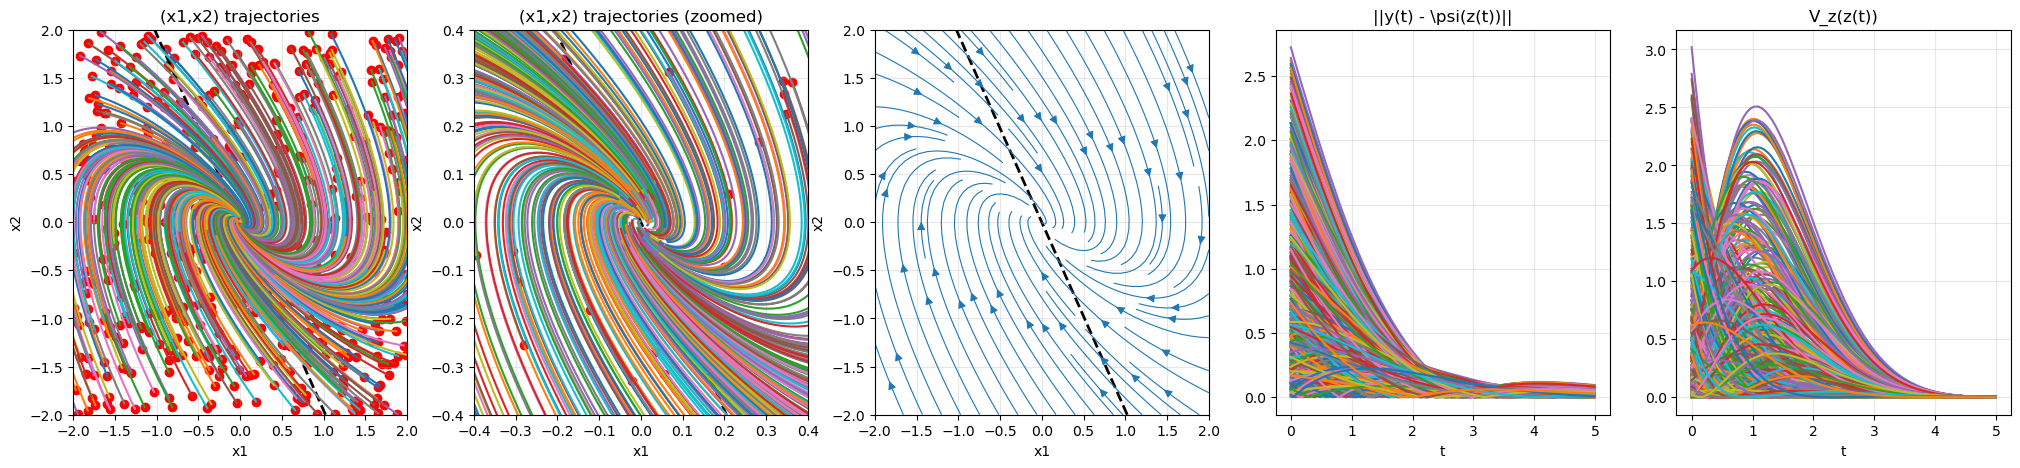

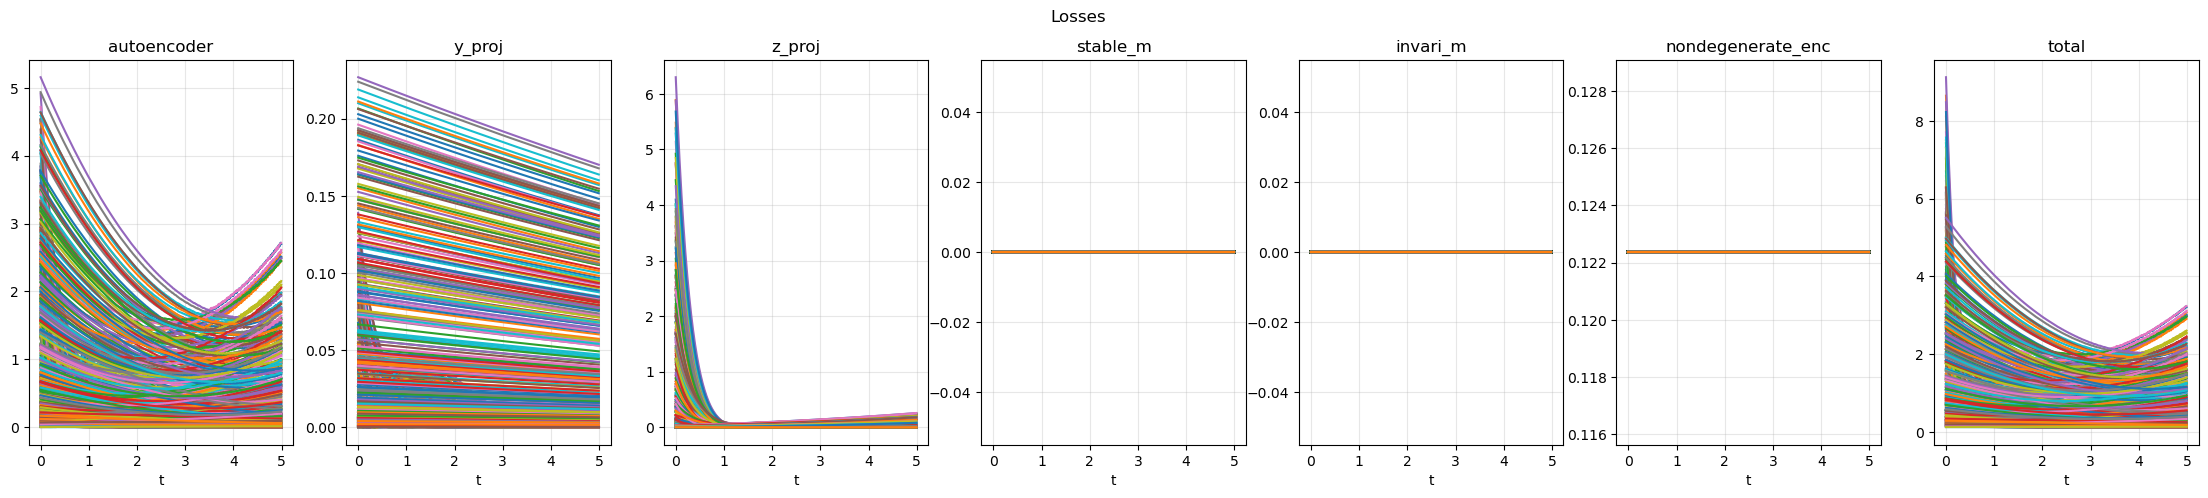

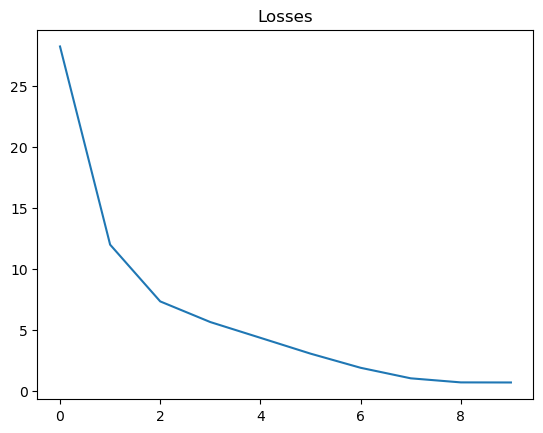


Params after training:
{'nn_decoder': {'bias': None,
                'kernel': Array([[-0.8239991 , -0.17596698],
       [-1.063171  , -0.17753425]], dtype=float32)},
 'nn_encoder': {'bias': None,
                'kernel': Array([[-0.25657558, -0.8231487 ],
       [-0.93448305,  0.4604664 ]], dtype=float32)},
 'nn_fy': {'bias': None, 'kernel': Array([[0.02928473]], dtype=float32)},
 'nn_fz': {'bias': None, 'kernel': Array([[ 0.84235364],
       [-0.2266662 ]], dtype=float32)},
 'nn_gy': {'bias': Array([-0.90634274], dtype=float32), 'kernel': Array([[0.00042135]], dtype=float32)},
 'nn_psi': {'bias': None, 'kernel': Array([[0.5116918]], dtype=float32)}}


100%|██████████| 10/10 [00:20<00:00,  2.05s/it, loss=4.01e-01, lr=5.00e-02]


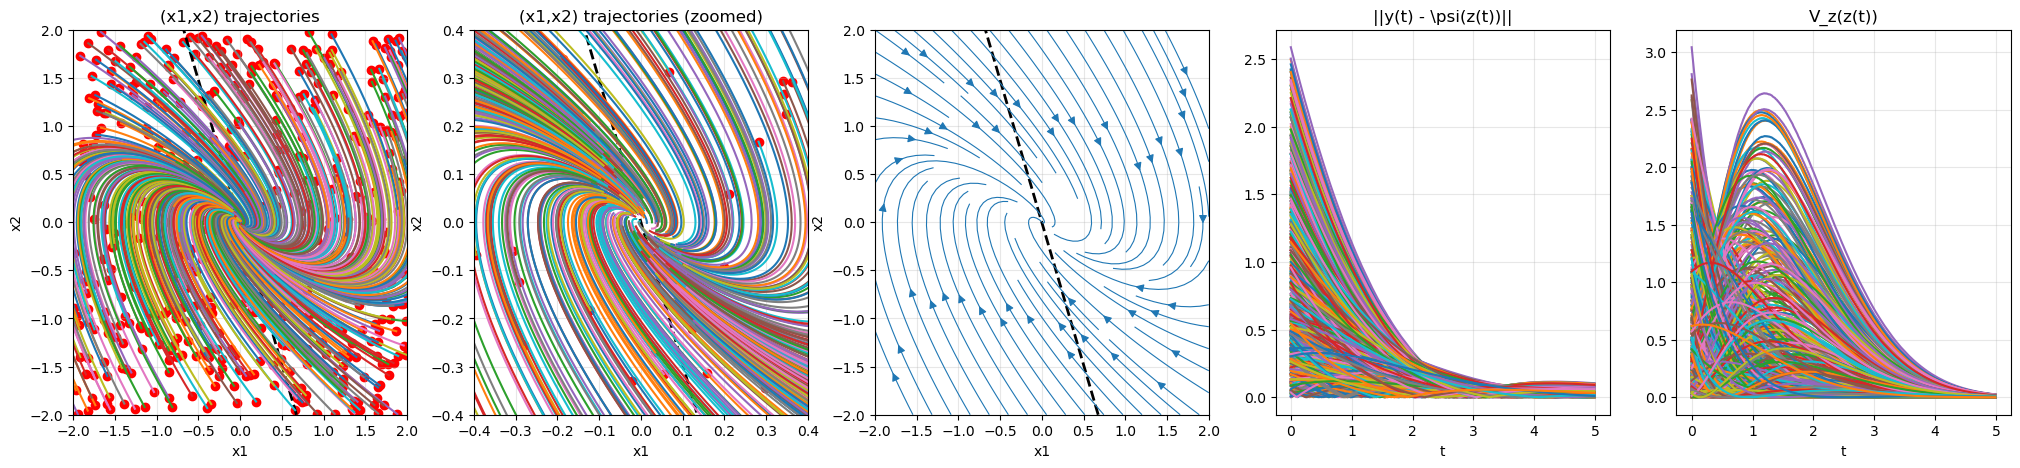

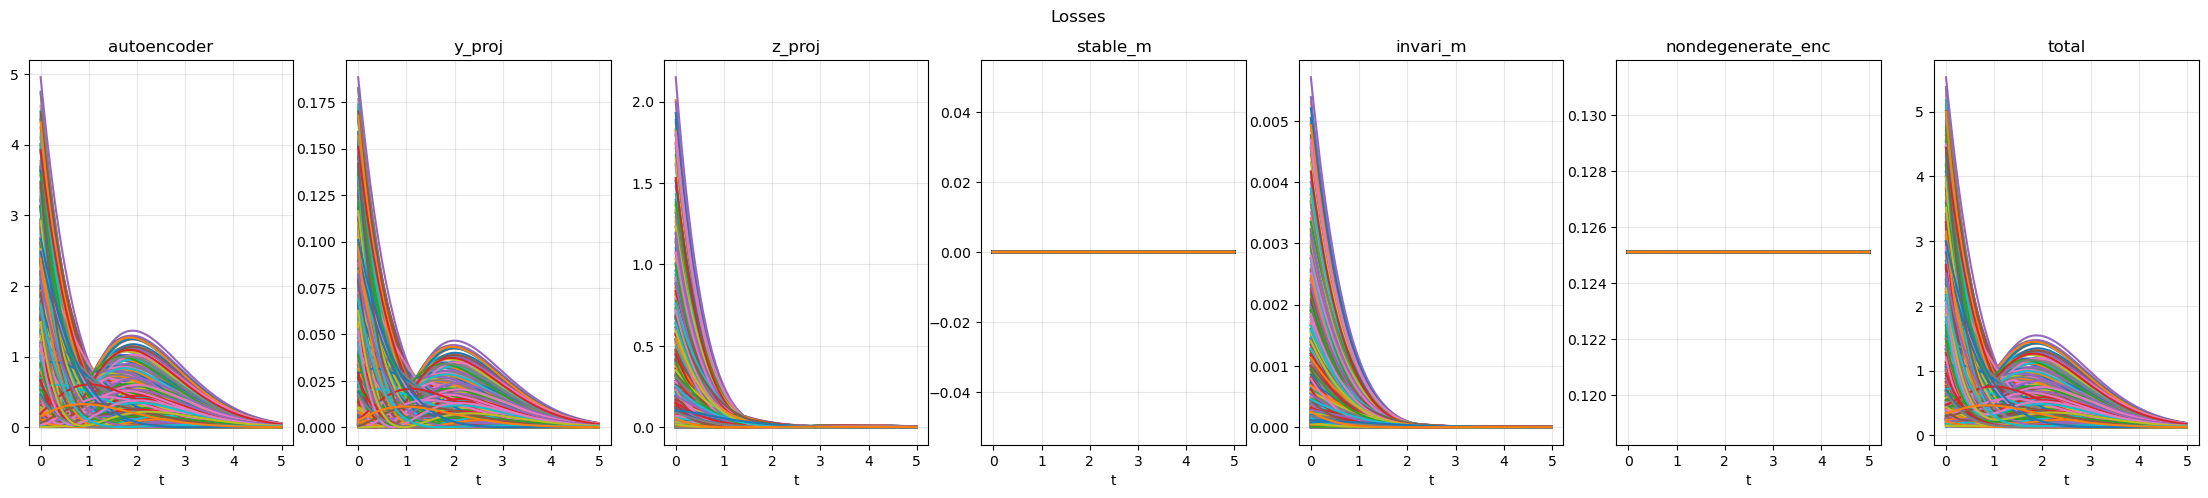

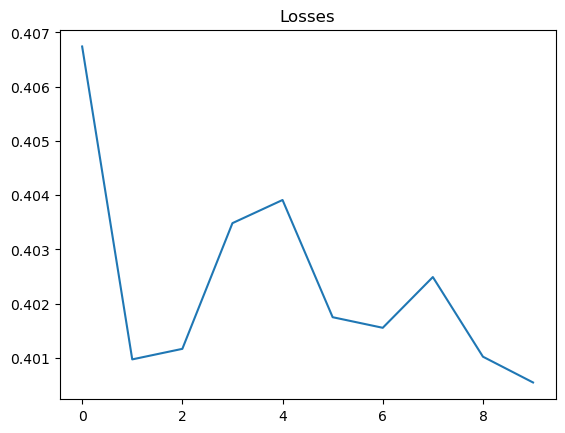


Params after training:
{'nn_decoder': {'bias': None,
                'kernel': Array([[-0.8239991 , -0.17596698],
       [-1.063171  , -0.17753425]], dtype=float32)},
 'nn_encoder': {'bias': None,
                'kernel': Array([[-0.25657558, -0.8231487 ],
       [-0.93448305,  0.4604664 ]], dtype=float32)},
 'nn_fy': {'bias': None, 'kernel': Array([[0.02928473]], dtype=float32)},
 'nn_fz': {'bias': None, 'kernel': Array([[ 0.84235364],
       [-0.2266662 ]], dtype=float32)},
 'nn_gy': {'bias': Array([-0.90634274], dtype=float32), 'kernel': Array([[0.00042135]], dtype=float32)},
 'nn_psi': {'bias': None, 'kernel': Array([[0.3378353]], dtype=float32)}}


In [1]:

%load_ext autoreload
%autoreload 2

import os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax, flax
from einops import rearrange
import jax.tree_util as jtu
from double_integrator import *
from my_train import *
from pprint import pprint
from functools import partial


cfg_rollout = CfgRollout()
cfg_rom = CfgDIROM()
cfg_train = CfgTrain()
cfg_data = CfgData()

ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
rng = jax.random.PRNGKey(42)
rom_nn = NNDoubleIntegratorROM(cfg_rom=cfg_rom)
rom_expert = DoubleIntegratorROM(cfg_rom=cfg_rom)

rom_nn.set_nn_params({
    # "nn_encoder": {"kernel": jnp.array([[0., 1.], [1., 0.]])},
    # "nn_decoder": {"kernel": jnp.array([[0., 1.], [1., 0.]])},
    "nn_gy":      {"kernel": jnp.array([[0.]]), "bias": jnp.array([1.])},
    # "nn_fy":      {"kernel": jnp.array([[0.]])},                      
    # "nn_fz":      {"kernel": jnp.array([[1.], [0.]])},                # ż = y
    "nn_psi":      {"kernel": jnp.array([[-0.4]])}, # on purpose give it a incorrect value.
})

print("Before training:")
pprint(rom_nn.get_nn_params(), depth=3, width=120)

integrator = Integrator(
    solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()),
    ts=ts
)


if (train_supervised:=True):
    # cfg_loss_dyn = CfgLoss(autoencoder=0.0, y_proj=1.0, z_proj=1.0, nondegenerate_enc=1.0, supervised=True)
    cfg_loss_dyn = CfgLoss(autoencoder=1.0, 
                           y_proj=1.0, z_proj=1.0, 
                           stable_m=1.0, invari_m=0.0,
                           nondegenerate_enc=1.0, supervised=True)
    train(rom_nn, rom_expert, integrator, cfg_train, cfg_data, cfg_loss_dyn, rng)

if (train_zd_policy_only:=True):
    cfg_loss_zd = CfgLoss(stable_m=1.0, invari_m=1.0, supervised=False)
    freeze_parameters(rom_nn, ["nn_encoder", "nn_decoder", "nn_fz", "nn_gy", "nn_fy"])
    train(rom_nn, rom_expert, integrator, cfg_train, cfg_data, cfg_loss_zd, rng)

In [2]:
nn_params =  rom_nn.get_nn_params()
E = nn_params["nn_encoder"]["kernel"]
D = nn_params["nn_decoder"]["kernel"]
print(E, D, E@D, D@E)

[[-0.25657558 -0.8231487 ]
 [-0.93448305  0.4604664 ]] [[-0.8239991  -0.17596698]
 [-1.063171   -0.17753425]] [[1.086566   0.19128592]
 [0.28045866 0.0826896 ]] [[0.37585622 0.5972469 ]
 [0.4386865  0.79339933]]


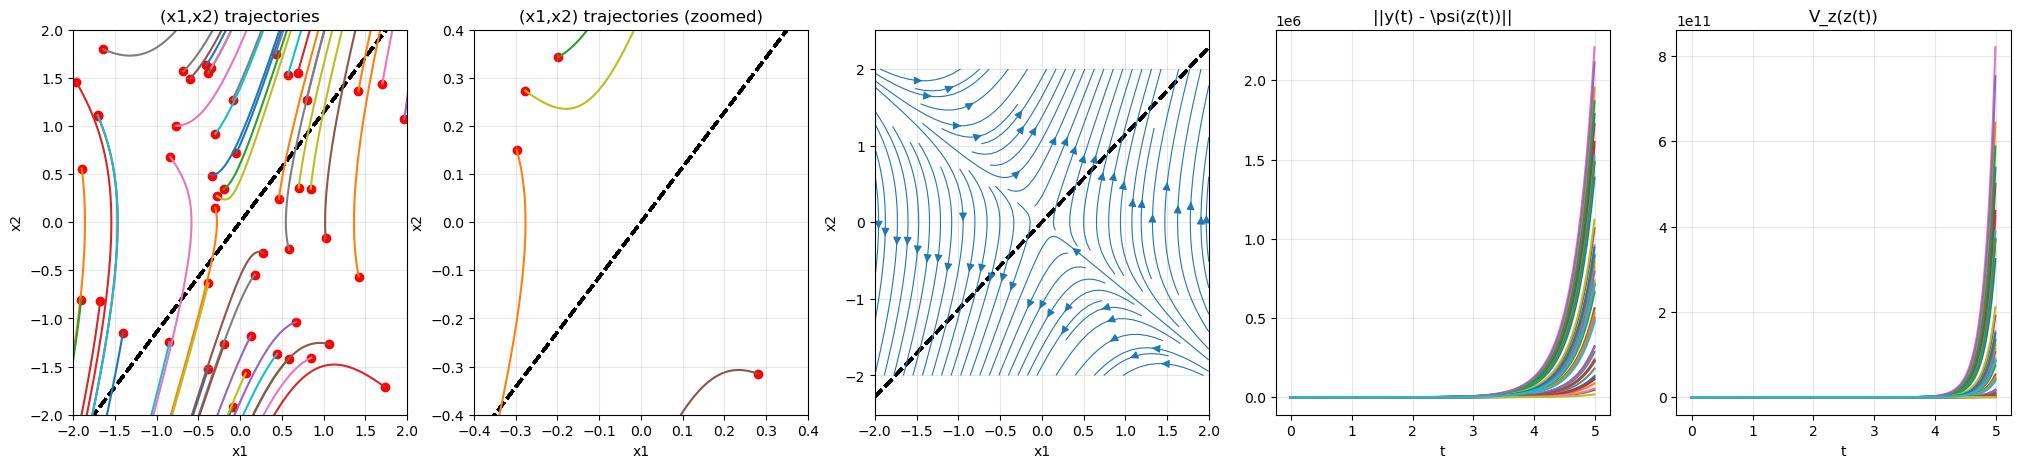

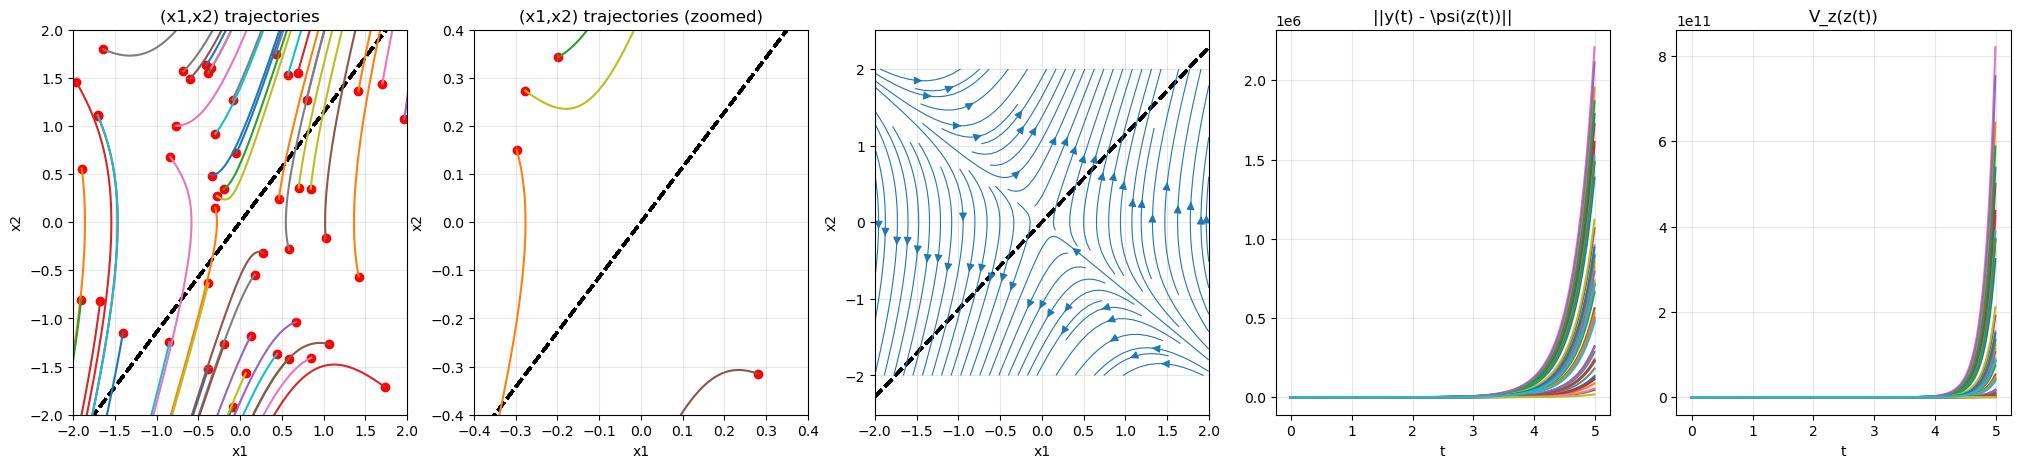

In [3]:
x0s = jax.random.uniform(rng, (50, 2), minval=-cfg_data.box_width, maxval=cfg_data.box_width)

int_out = integrator.apply(x0s, rom=rom_nn)
int_out_expert = integrator.apply(x0s, rom=rom_expert)
aux_out = integrator.post_apply(int_out, rom=rom_nn)
loss_out = integrator.compute_loss(int_out, int_out_expert, rom=rom_nn, cfg_loss=CfgLoss())

make_traj_plots(rom_nn, int_out, aux_out)

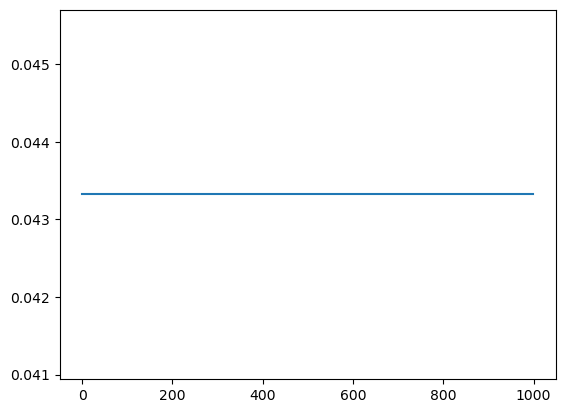

0.043322477
0.9473318


In [ ]:
@nnx.jit
def step_only_margin(m: NNDoubleIntegratorROM):
    
    def loss_fn(_m: NNDoubleIntegratorROM):
        z = jnp.array([1.0])  # unused by hinge
        return jnp.mean(_m.loss_stable_m(z)), None
    return nnx.value_and_grad(loss_fn, has_aux=True)(m)


tx = optax.adam(3e-3)  # simple and known-good while debugging
opt = nnx.Optimizer(rom, tx, wrt=nnx.Param)

k_vals = []
for _ in range(1000):
    (L, _), grads = step_only_margin(rom)
    opt.update(grads)
    k_vals.append(rom.nn_psi.kernel.value.squeeze())

plt.plot(k_vals)
plt.show()
print(k_vals[-1])
print(jax.nn.softplus(0.5*rom.cfg_rom.lamv -k_vals[-1]))